# Generating Digits with a Diffusion Model

This notebook provides you with a complete code example to generate MNIST digits with a diffusion model.

## Loading the MNIST Dataset with PyTorch

Implement the normalization of the digits ...

In [1]:
from torchvision.transforms import Compose, Normalize, ToTensor

trans = Compose([ToTensor(), Normalize(mean=[0.5], std=[0.5], inplace=True)])

... import the MNIST digits ...

In [2]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=trans, download=True)

... and plot some of the transformed MNIST digits.

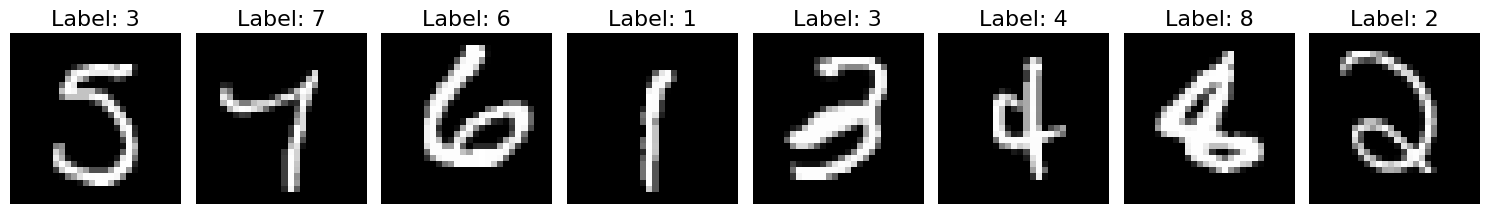

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
    img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}", fontsize=16)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Forward Process

Define the device on which the computations are performed ...

In [4]:
import torch

def get_device():
    """Select device where to perform computations."""
    if torch.cuda.is_available():
        return torch.device("cuda:0")
    # elif torch.backends.mps.is_available():
    #     return torch.device("mps")
    else:
        return torch.device("cpu")

In [5]:
device = get_device()

In [6]:
print(device)

cpu


... implement the forward diffusion process ...

In [7]:
class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02,
                 device=device):
        """Initialize the diffusion model."""
        self.steps, self.device = steps, device
        self.beta = torch.linspace(beta_start, beta_end, self.steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

... sampling images in the forward diffusion process ..

In [8]:
diffusion = Diffusion(steps=401, beta_start=0.0001, beta_end=0.02)

clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

steps = [0, 100, 200, 300, 400] 
noisy_images = []
for t in steps:
    noisy_image, noise = diffusion.forward_diffusion(
        x=clean_image[None, ...].to(device), t=torch.tensor([t]).to(device),
    )
    noisy_images.append(noisy_image)

... and visualize the noisy digits generated in the forward diffusion process.

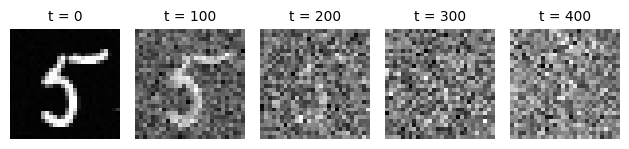

In [9]:
fig, axs = plt.subplots(1, len(steps))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
    ax.set_title(f"t = {steps[i]}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

## Implementing the Reverse Diffusion Process

Update the `Diffusion` class to implement the reverse diffusion process.

In [10]:
from tqdm import tqdm

class Diffusion:
    """Denoising diffusion probabilstic model (DDPM)."""
    
    def __init__(self, steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28,
                 device=device):
        """Initialize the diffusion model."""
        self.steps, self.img_size, self.device = steps, img_size, device
        self.beta = torch.linspace(beta_start, beta_end, self.steps).to(device)
        self.alpha = 1.0 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def forward_diffusion(self, x, t):
        """Implement the forward diffusion process."""
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = \
            torch.sqrt(1 - self.alpha_bar[t])[:, None, None, None]
        noise = torch.randn_like(x)
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise
    
    def reverse_diffusion(self, model, n_images, n_channels, pos_enc_dim, 
                          pos_enc_func, fix_noise=None, save_time_steps=None):
        """Reverse diffusion process"""
        with torch.no_grad():
            if fix_noise is not None:
                x = fix_noise.to(self.device)
            else:
                x = torch.randn(
                    (n_images, n_channels, self.img_size, self.img_size)
                ).to(self.device)
            
            denoised_images = []
            for i in tqdm(reversed(range(0, self.steps)),
                          desc="U-Net inference", total=self.steps):
                t = (torch.ones(n_images) * i).long()
                t_pos_enc = (pos_enc_func(t.unsqueeze(1), pos_enc_dim)
                             .to(self.device))
                predicted_noise = model(x=x, t=t_pos_enc)
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                noise = torch.randn_like(x) if i > 0 else torch.zeros_like(x)
                x = (1 / torch.sqrt(alpha) * (x - ((1 - alpha) 
                     / torch.sqrt(1 - alpha_bar)) * predicted_noise) 
                     + torch.sqrt(1-alpha) * noise)
                if i in save_time_steps: denoised_images.append(x)

            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images

## Defining the Position Encoding Function

Implement the position encoding function ...

In [11]:
def positional_encoding(t, enc_dim):
    """Encode position information with a sinusoid."""
    scaled_positions = torch.arange(0, enc_dim, 2).float() / enc_dim
    frequency = 10000 ** scaled_positions
    inverse_frequency = (1.0 / frequency).to(t.device)
    angle = t.repeat(1, enc_dim // 2) * inverse_frequency
    pos_enc_a, pos_enc_b = torch.sin(angle), torch.cos(angle)
    pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
    return pos_enc

... sinusoidal position encodings for different time steps ...

In [12]:
pos_enc_dim = 256

pos_encs = []
for i in range(0, 100):
    t = torch.tensor([i])
    pos_enc = positional_encoding(t, pos_enc_dim)
    pos_encs.append(pos_enc.squeeze())
pos_encs = torch.stack(pos_encs)

... and visualize the position encodings.

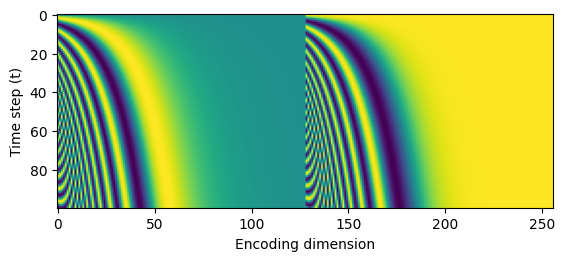

In [13]:
fig = plt.figure()
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Encoding dimension")
plt.ylabel("Time step (t)")
plt.show()

## Defining the Attention U-Net

In [14]:
import deeplay as dl

pos_enc_dim = 256

unet = dl.AttentionUNet(in_channels=1, channels=[32, 64, 128], 
                        base_channels=[256, 256], 
                        channel_attention=[True, True, True], out_channels=1, 
                        position_embedding_dim=pos_enc_dim)
unet.build()
unet.to(device);

## Training the Diffusion Model

Define the data loader ...

In [15]:
from torch.utils.data import DataLoader

loader = DataLoader(dataset=trainset, batch_size=128, shuffle=True)

... define the loss function ...

In [16]:
criterion = torch.nn.MSELoss()

... define the optimizer ...

In [17]:
optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

...  instantiate the diffusion class for training ...

In [18]:
diffusion = Diffusion(steps=1000, beta_start=1e-4, beta_end=0.02, img_size=28)

...implement a function to prepare the data ...

In [19]:
def prepare_data(image, steps=1000, device=device):
    """Prepare data."""
    batch_size = image.shape[0]
    t = torch.randint(low=0, high=steps, size=(batch_size,)).to(device)
    image = image.to(device)
    x_t, noise = diffusion.forward_diffusion(image, t)
    t_pos_enc = positional_encoding(t.unsqueeze(1), pos_enc_dim)
    return x_t.to(device), t_pos_enc.to(device), noise.to(device)

... implement the training cycle ...


Epoch 1/20
__________
Batch 1/469: Train loss: 1.7020
Batch 101/469: Train loss: 0.1598
Batch 201/469: Train loss: 0.1066
Batch 301/469: Train loss: 0.0800
Batch 401/469: Train loss: 0.0622
----------
Epoch 1/20 : Train loss: 0.1591, Time taken: 0:11:39.077212


U-Net inference: 100%|██████████| 1000/1000 [00:47<00:00, 20.99it/s]


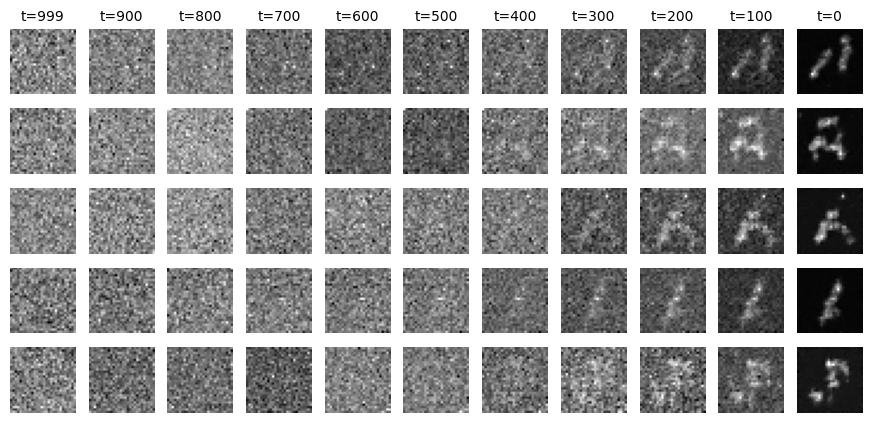


Epoch 2/20
__________
Batch 1/469: Train loss: 0.0603
Batch 101/469: Train loss: 0.0627
Batch 201/469: Train loss: 0.0577
Batch 301/469: Train loss: 0.0479
Batch 401/469: Train loss: 0.0336
----------
Epoch 2/20 : Train loss: 0.0517, Time taken: 0:11:01.985264


U-Net inference: 100%|██████████| 1000/1000 [00:39<00:00, 25.07it/s]


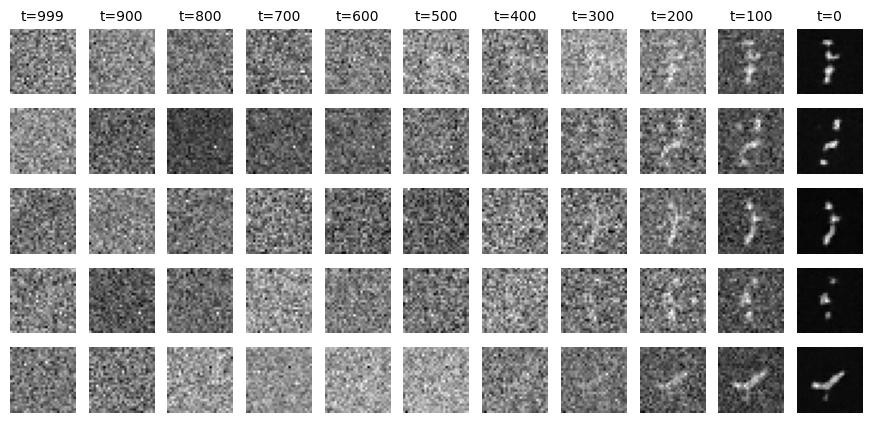


Epoch 3/20
__________
Batch 1/469: Train loss: 0.0487
Batch 101/469: Train loss: 0.0372
Batch 201/469: Train loss: 0.0371
Batch 301/469: Train loss: 0.0316
Batch 401/469: Train loss: 0.0494
----------
Epoch 3/20 : Train loss: 0.0412, Time taken: 0:11:01.240133


U-Net inference: 100%|██████████| 1000/1000 [00:39<00:00, 25.05it/s]


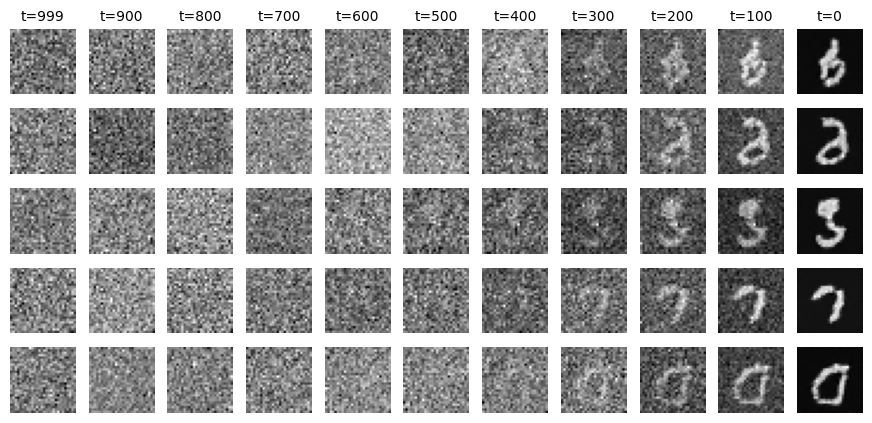


Epoch 4/20
__________
Batch 1/469: Train loss: 0.0401
Batch 101/469: Train loss: 0.0437
Batch 201/469: Train loss: 0.0387
Batch 301/469: Train loss: 0.0322
Batch 401/469: Train loss: 0.0469
----------
Epoch 4/20 : Train loss: 0.0366, Time taken: 0:11:02.374363


U-Net inference: 100%|██████████| 1000/1000 [00:40<00:00, 24.92it/s]


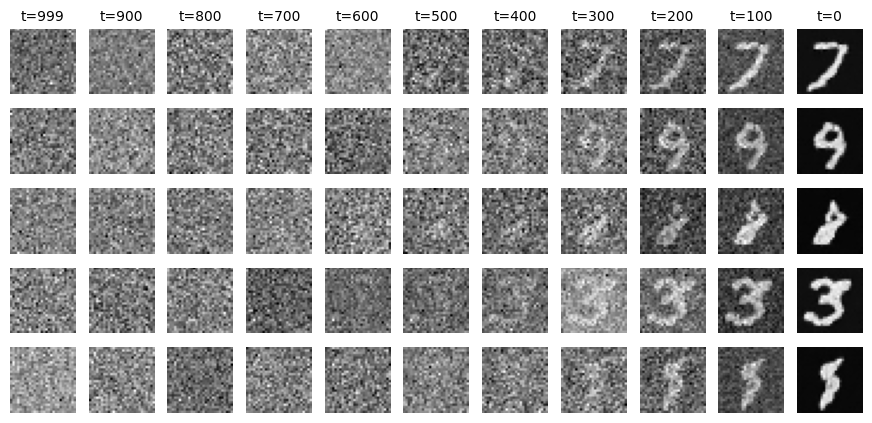


Epoch 5/20
__________
Batch 1/469: Train loss: 0.0431
Batch 101/469: Train loss: 0.0283
Batch 201/469: Train loss: 0.0346
Batch 301/469: Train loss: 0.0350
Batch 401/469: Train loss: 0.0253
----------
Epoch 5/20 : Train loss: 0.0340, Time taken: 0:10:59.735848


U-Net inference: 100%|██████████| 1000/1000 [00:35<00:00, 28.52it/s]


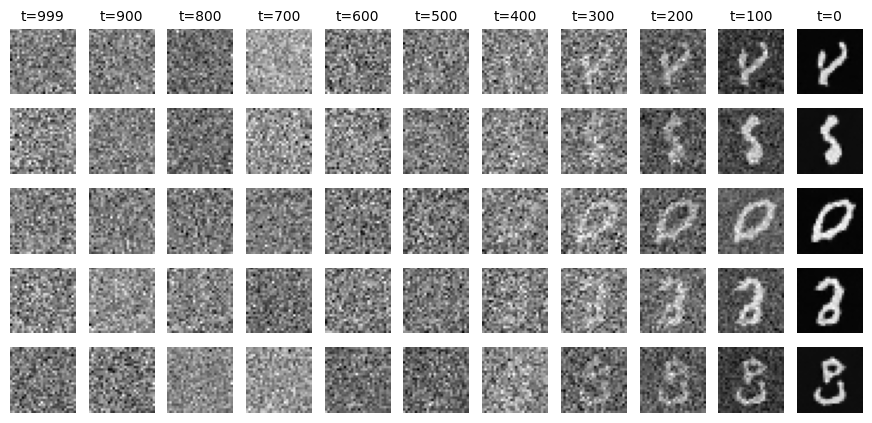


Epoch 6/20
__________
Batch 1/469: Train loss: 0.0362
Batch 101/469: Train loss: 0.0296
Batch 201/469: Train loss: 0.0395
Batch 301/469: Train loss: 0.0345
Batch 401/469: Train loss: 0.0314
----------
Epoch 6/20 : Train loss: 0.0325, Time taken: 0:11:00.540633


U-Net inference: 100%|██████████| 1000/1000 [00:40<00:00, 24.53it/s]


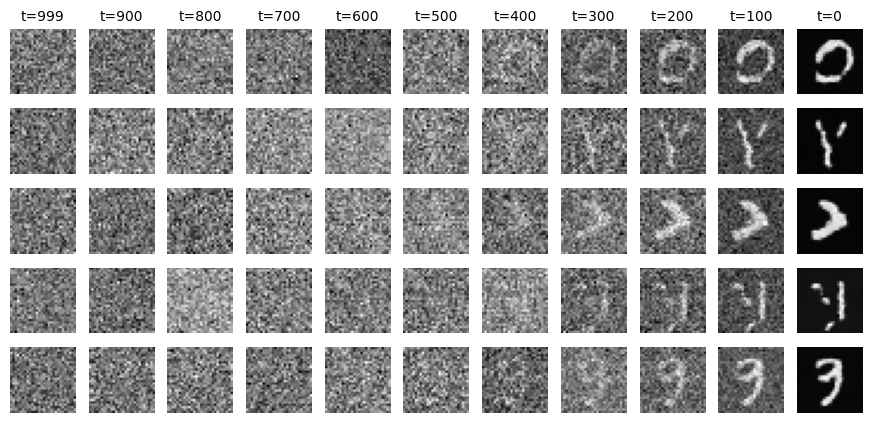


Epoch 7/20
__________
Batch 1/469: Train loss: 0.0356
Batch 101/469: Train loss: 0.0267
Batch 201/469: Train loss: 0.0410
Batch 301/469: Train loss: 0.0276
Batch 401/469: Train loss: 0.0226
----------
Epoch 7/20 : Train loss: 0.0311, Time taken: 0:11:01.281279


U-Net inference: 100%|██████████| 1000/1000 [00:37<00:00, 27.01it/s]


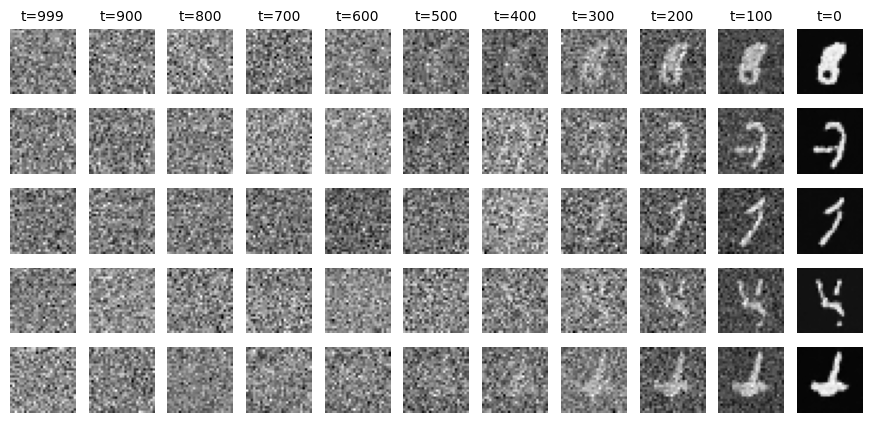


Epoch 8/20
__________
Batch 1/469: Train loss: 0.0290
Batch 101/469: Train loss: 0.0309
Batch 201/469: Train loss: 0.0315
Batch 301/469: Train loss: 0.0328
Batch 401/469: Train loss: 0.0252
----------
Epoch 8/20 : Train loss: 0.0300, Time taken: 0:11:00.385324


U-Net inference: 100%|██████████| 1000/1000 [00:41<00:00, 24.07it/s]


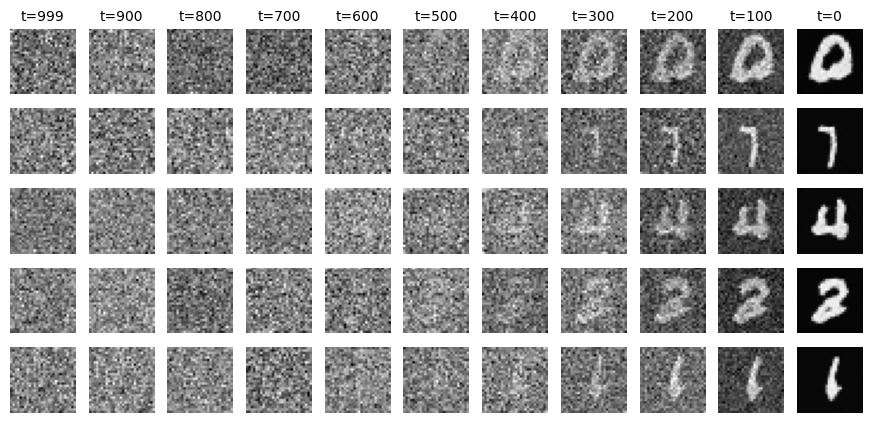


Epoch 9/20
__________
Batch 1/469: Train loss: 0.0338
Batch 101/469: Train loss: 0.0286
Batch 201/469: Train loss: 0.0255
Batch 301/469: Train loss: 0.0248
Batch 401/469: Train loss: 0.0316
----------
Epoch 9/20 : Train loss: 0.0289, Time taken: 0:11:02.207098


U-Net inference: 100%|██████████| 1000/1000 [00:40<00:00, 24.57it/s]


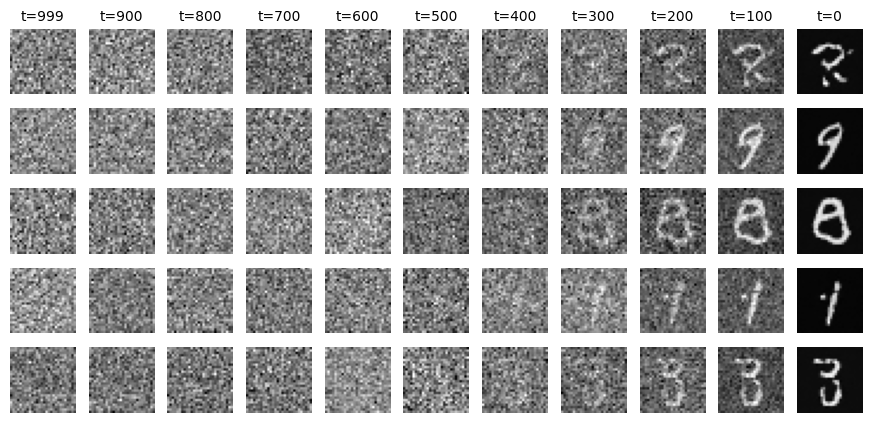


Epoch 10/20
__________
Batch 1/469: Train loss: 0.0334
Batch 101/469: Train loss: 0.0258
Batch 201/469: Train loss: 0.0300
Batch 301/469: Train loss: 0.0335
Batch 401/469: Train loss: 0.0257
----------
Epoch 10/20 : Train loss: 0.0280, Time taken: 0:11:02.637105


U-Net inference: 100%|██████████| 1000/1000 [00:43<00:00, 22.88it/s]


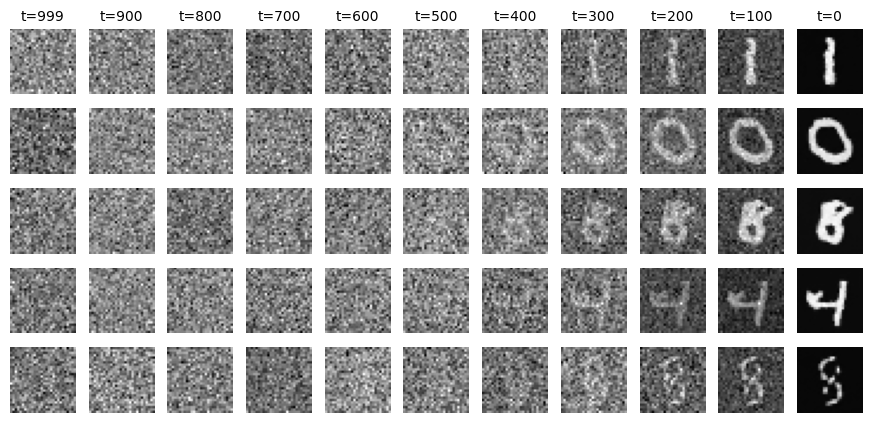


Epoch 11/20
__________
Batch 1/469: Train loss: 0.0291
Batch 101/469: Train loss: 0.0322
Batch 201/469: Train loss: 0.0270
Batch 301/469: Train loss: 0.0274
Batch 401/469: Train loss: 0.0284
----------
Epoch 11/20 : Train loss: 0.0276, Time taken: 0:11:02.043826


U-Net inference: 100%|██████████| 1000/1000 [00:40<00:00, 24.87it/s]


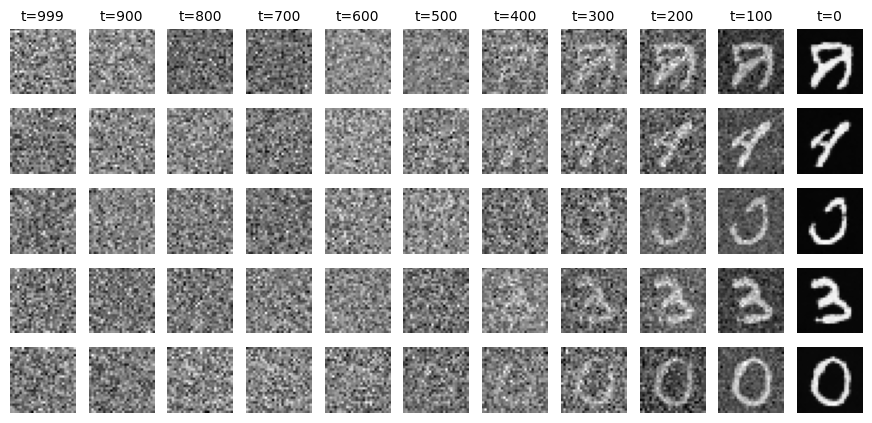


Epoch 12/20
__________
Batch 1/469: Train loss: 0.0316
Batch 101/469: Train loss: 0.0244
Batch 201/469: Train loss: 0.0346
Batch 301/469: Train loss: 0.0264
Batch 401/469: Train loss: 0.0284
----------
Epoch 12/20 : Train loss: 0.0272, Time taken: 0:11:02.633547


U-Net inference: 100%|██████████| 1000/1000 [00:38<00:00, 26.17it/s]


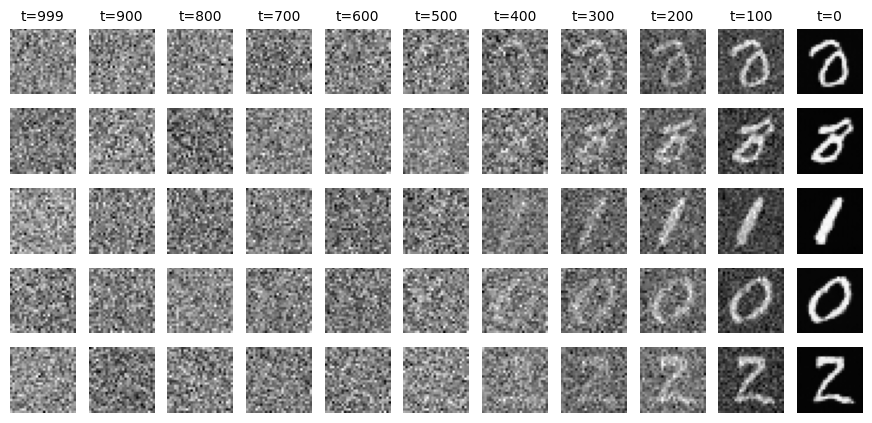


Epoch 13/20
__________
Batch 1/469: Train loss: 0.0254
Batch 101/469: Train loss: 0.0291
Batch 201/469: Train loss: 0.0232
Batch 301/469: Train loss: 0.0317
Batch 401/469: Train loss: 0.0263
----------
Epoch 13/20 : Train loss: 0.0265, Time taken: 0:11:03.251728


U-Net inference: 100%|██████████| 1000/1000 [00:41<00:00, 23.81it/s]


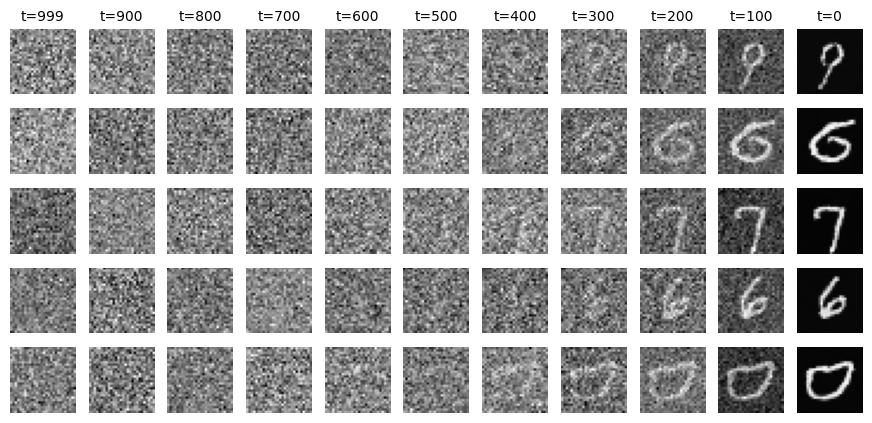


Epoch 14/20
__________
Batch 1/469: Train loss: 0.0297
Batch 101/469: Train loss: 0.0291
Batch 201/469: Train loss: 0.0266
Batch 301/469: Train loss: 0.0255
Batch 401/469: Train loss: 0.0227
----------
Epoch 14/20 : Train loss: 0.0261, Time taken: 0:11:01.004952


U-Net inference: 100%|██████████| 1000/1000 [00:37<00:00, 26.61it/s]


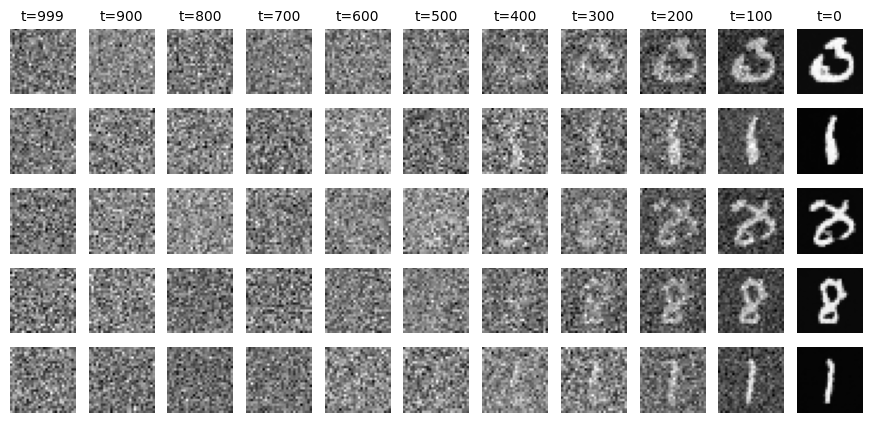


Epoch 15/20
__________
Batch 1/469: Train loss: 0.0231
Batch 101/469: Train loss: 0.0330
Batch 201/469: Train loss: 0.0216
Batch 301/469: Train loss: 0.0230
Batch 401/469: Train loss: 0.0285
----------
Epoch 15/20 : Train loss: 0.0258, Time taken: 0:11:00.564847


U-Net inference: 100%|██████████| 1000/1000 [00:39<00:00, 25.33it/s]


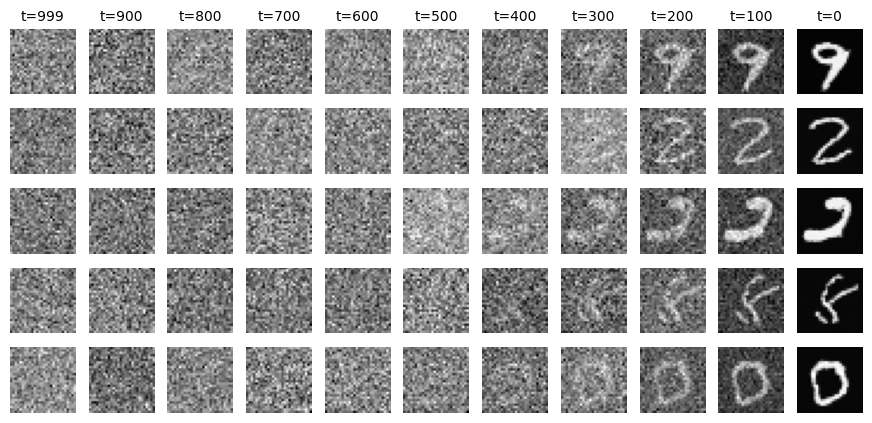


Epoch 16/20
__________
Batch 1/469: Train loss: 0.0280
Batch 101/469: Train loss: 0.0229
Batch 201/469: Train loss: 0.0278
Batch 301/469: Train loss: 0.0217
Batch 401/469: Train loss: 0.0242
----------
Epoch 16/20 : Train loss: 0.0256, Time taken: 0:11:01.590418


U-Net inference: 100%|██████████| 1000/1000 [00:39<00:00, 25.11it/s]


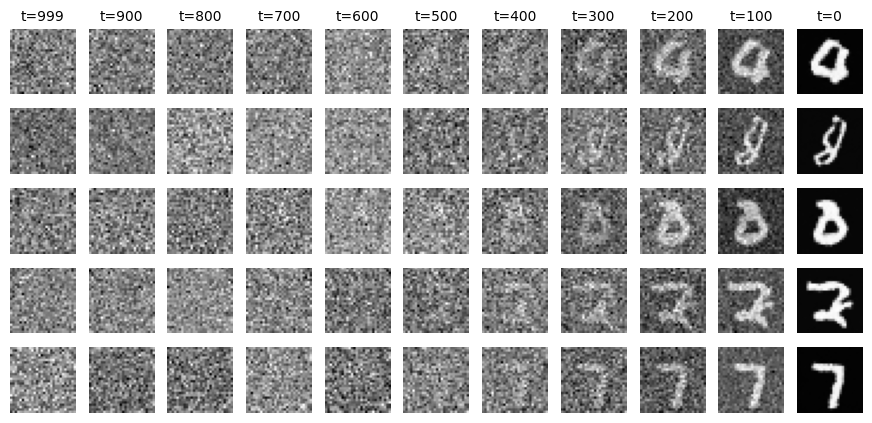


Epoch 17/20
__________
Batch 1/469: Train loss: 0.0209
Batch 101/469: Train loss: 0.0252
Batch 201/469: Train loss: 0.0258
Batch 301/469: Train loss: 0.0195
Batch 401/469: Train loss: 0.0250
----------
Epoch 17/20 : Train loss: 0.0254, Time taken: 0:11:00.961664


U-Net inference: 100%|██████████| 1000/1000 [00:39<00:00, 25.13it/s]


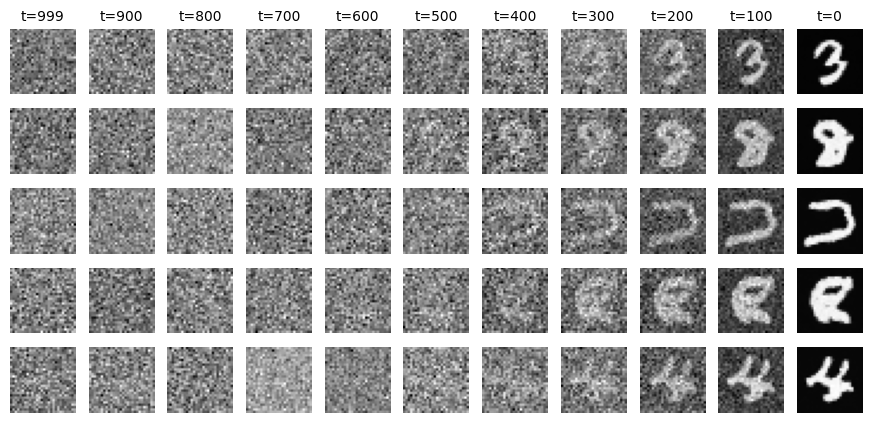


Epoch 18/20
__________
Batch 1/469: Train loss: 0.0262
Batch 101/469: Train loss: 0.0230
Batch 201/469: Train loss: 0.0253
Batch 301/469: Train loss: 0.0217
Batch 401/469: Train loss: 0.0214
----------
Epoch 18/20 : Train loss: 0.0248, Time taken: 0:11:02.125746


U-Net inference: 100%|██████████| 1000/1000 [00:44<00:00, 22.46it/s]


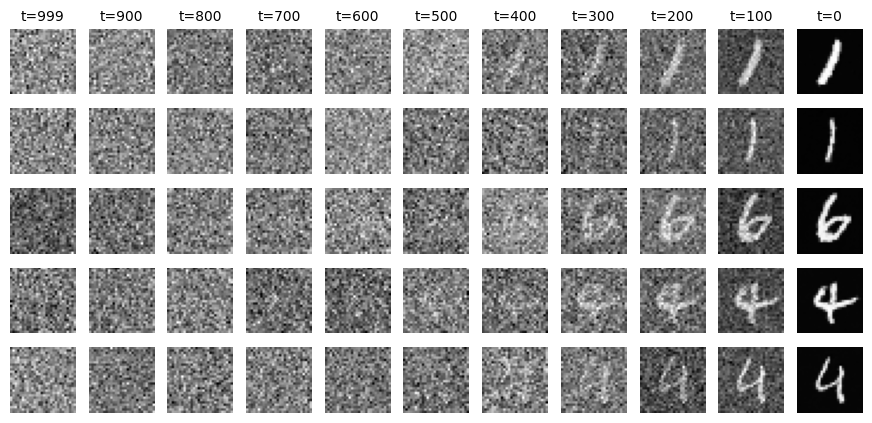


Epoch 19/20
__________
Batch 1/469: Train loss: 0.0244
Batch 101/469: Train loss: 0.0221
Batch 201/469: Train loss: 0.0253
Batch 301/469: Train loss: 0.0189
Batch 401/469: Train loss: 0.0250
----------
Epoch 19/20 : Train loss: 0.0247, Time taken: 0:11:01.931587


U-Net inference: 100%|██████████| 1000/1000 [00:37<00:00, 26.51it/s]


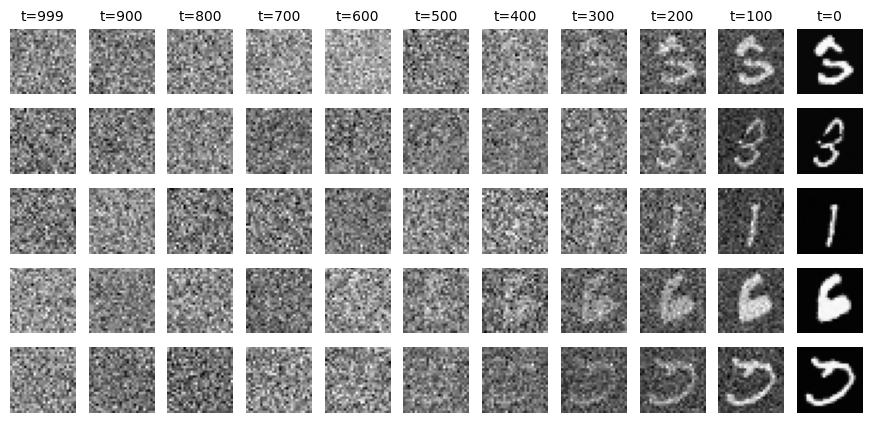


Epoch 20/20
__________
Batch 1/469: Train loss: 0.0232
Batch 101/469: Train loss: 0.0228
Batch 201/469: Train loss: 0.0231
Batch 301/469: Train loss: 0.0244
Batch 401/469: Train loss: 0.0272
----------
Epoch 20/20 : Train loss: 0.0245, Time taken: 0:11:02.717211


U-Net inference: 100%|██████████| 1000/1000 [00:38<00:00, 26.23it/s]


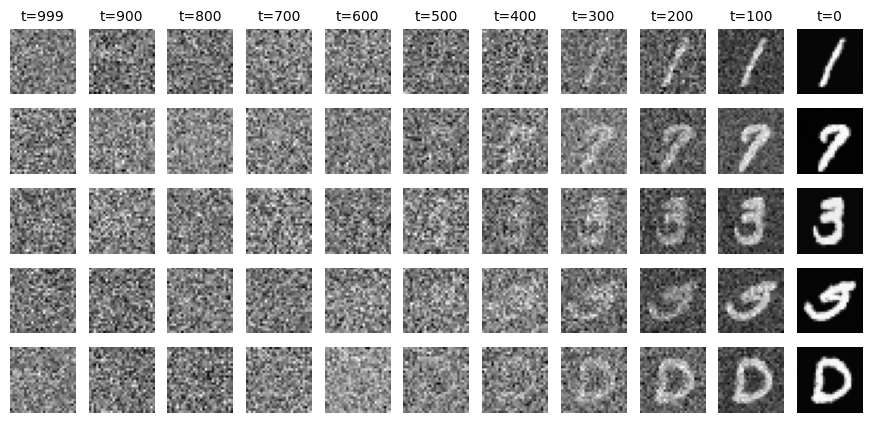

In [20]:
import time
from datetime import timedelta

epochs = 20

n_images = 5
save_time_steps = [999, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0]
train_loss = []
for epoch in range(epochs):
    unet.train()
    
    start_time = time.time()
    num_batches = len(loader)

    print("\n" + f"Epoch {epoch + 1}/{epochs}" + "\n" + "_" * 10)
    
    running_loss = 0.0
    for batch_idx, (images, class_labels) in enumerate(loader, start=0):
        x_t, t_pos_enc, noise = prepare_data(images)

        outputs = unet(x=x_t, t=t_pos_enc)

        optimizer.zero_grad()
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f"Batch {batch_idx + 1}/{num_batches}: "
                  + f"Train loss: {loss.item():.4f}")
        running_loss += loss.item()

    train_loss.append(running_loss / len(loader))
    end_time = time.time()

    print("-" * 10 + "\n" + f"Epoch {epoch + 1}/{epochs} : " 
          + f"Train loss: {train_loss[-1]:.4f}, " 
          + f"Time taken: {timedelta(seconds=end_time - start_time)}")
    
    unet.eval()
    generated_images = diffusion.reverse_diffusion(
        model=unet, n_images=n_images, n_channels=1, pos_enc_dim=pos_enc_dim,
        pos_enc_func=positional_encoding, save_time_steps=save_time_steps,
    )

    fig = plt.figure(figsize=(len(save_time_steps), n_images))
    for idx in range(n_images):
        image_reverse_diff_traj = generated_images[idx]
        for j in range(len(image_reverse_diff_traj)):
            plt.subplot(n_images, len(image_reverse_diff_traj), 
                        idx * len(image_reverse_diff_traj) + j + 1)
            plt.imshow(image_reverse_diff_traj[j]
                       .permute(1, 2, 0).cpu().numpy(), cmap="gray")
            if idx == 0: plt.title(f"t={save_time_steps[j]}", fontsize=10)
            plt.axis("off")
    plt.show()
    plt.close()

## Sampling Images From Fixed Noise

U-Net inference: 100%|██████████| 1000/1000 [00:10<00:00, 99.56it/s]


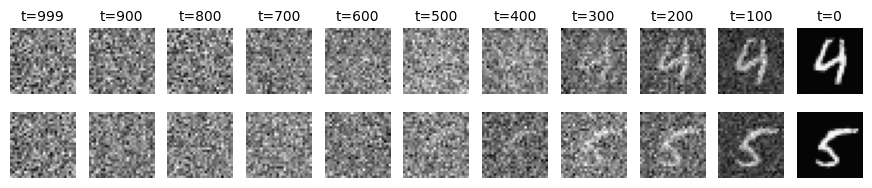

In [21]:
unet.eval()

fix_noise = torch.randn((1, 1, 28, 28))
n_images_fix_noise = 2

fig = plt.figure(figsize=(len(save_time_steps), n_images_fix_noise))
for idx in range(n_images_fix_noise):
    generated_images = diffusion.reverse_diffusion(
        model=unet, n_images=1, n_channels=1, fix_noise=fix_noise,
        pos_enc_dim=pos_enc_dim, pos_enc_func=positional_encoding,
        save_time_steps=save_time_steps,
    )
    
    image_reverse_diff_traj = generated_images[0]
    for j in range(len(image_reverse_diff_traj)):
        plt.subplot(n_images_fix_noise, len(image_reverse_diff_traj), 
                    idx * len(image_reverse_diff_traj) + j + 1)
        plt.imshow(image_reverse_diff_traj[j]
                   .permute(1, 2, 0).cpu().numpy(), cmap="gray")
        if idx == 0: plt.title(f"t={save_time_steps[j]}", fontsize=10)
        plt.axis("off")
plt.show()